# **REFERENCE**

[Kaggle - Fruit Vegetable Classification](https://www.kaggle.com/code/databeru/fruit-and-vegetable-classification)

# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# **1. Loading and Preprocessing**

Upload API user kaggle and download dataset from kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maulinnasari","key":"540b6930d67576109d63c5ad20f8f4a5"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d maulinnasari/indonesianfoods

100% 112M/112M [00:01<00:00, 97.5MB/s] 
100% 112M/112M [00:01<00:00, 86.9MB/s]


In [ ]:
!unzip -qq /content/indonesianfoods.zip

In [ ]:
train_dir = Path('/content/indonesian foods/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/indonesian foods/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/indonesian foods/val')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

Create a DataFrame w/ the filepath and the labels of the pictures

In [ ]:
def preprocess(filepath):
  labels = [str(filepath[i]).split("/")[-2]
            for i in range(len(filepath))]
  
  filepath = pd.Series(filepath, name='Filepath').astype(str)
  
  labels = pd.Series(labels, name='Label')

  # concantenate filepaths and labels
  df = pd.concat([filepath, labels], axis=1)

  df = df.sample(frac=1).reset_index(drop = True)

  return df

train_df = preprocess(train_filepaths)
test_df = preprocess(test_filepaths)
val_df = preprocess(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 719

Number of different labels: 18

Labels: ['Rendang' 'Rawon' 'Nasi Pecel' 'Soto Banjar' 'Gudeg' 'Ayam Betutu'
 'Peuyeum' 'Papeda' 'Serabi' 'Kerak Telor' 'Mie Aceh' 'Pempek'
 'Nasi Kuning' 'Beberuk Terong' 'Soto Lamongan' 'Tahu Sumedang'
 'Sate Madura' 'Coto Makassar']


In [ ]:
train_df.head(5)

,Filepath,Label
0,/content/indonesian foods/train/Rendang/Rendan...,Rendang
1,/content/indonesian foods/train/Rawon/Rawon-25...,Rawon
2,/content/indonesian foods/train/Nasi Pecel/nas...,Nasi Pecel
3,/content/indonesian foods/train/Rawon/Rawon-5.jpg,Rawon
4,/content/indonesian foods/train/Soto Banjar/so...,Soto Banjar


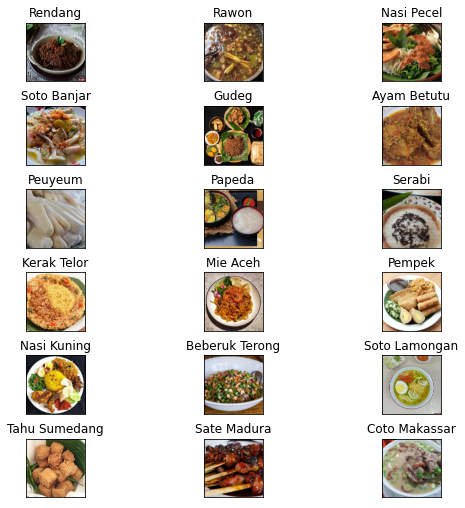

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# **2. Load the Images with a generator and Data Augmentation**

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 719 validated image filenames belonging to 18 classes.
Found 180 validated image filenames belonging to 18 classes.
Found 90 validated image filenames belonging to 18 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


# **3. Train the model**

In [ ]:
def train_model(n_classes,num_epochs,batch):
  K.clear_session()

  img_width, img_height = 224, 224
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
  x = tf.keras.layers.Dense(128, activation='relu')(x)

  model = Sequential([
      pretrained_model,
      Dense(200, activation='relu',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      ),
      Dropout(0.3),
      Dense(n_classes, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()

  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_images,
                      validation_data=val_images,
                      batch_size = batch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  return history

In [ ]:
n_classes = 18
epochs = 50
batch = 32

train_files = sum([len(files) for i, j, files in os.walk("/content/indonesian foods/train")])
val_files = sum([len(files) for i, j, files in os.walk("/content/indonesian foods/val")])

nb_train_samples = train_files
nb_validation_samples = val_files

history = train_model(n_classes,epochs,batch)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 200)               256200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 18)                3618      
                                                                 
Total params: 2,517,802
Trainable params: 259,818
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 2.2234 - accuracy: 0.3672
Epoch 1: val

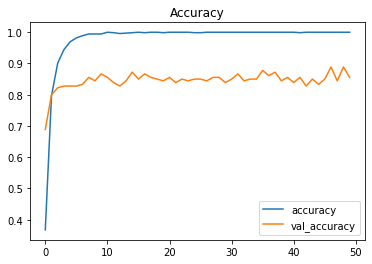

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

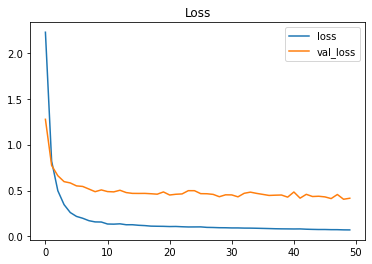

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# **4. Visualize the result**

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('/content/bestmodel_18class.hdf5',compile = False)

CPU times: user 1.31 s, sys: 36.1 ms, total: 1.34 s
Wall time: 1.32 s


In [ ]:
# Predict the label of the test_images
pred = model_best.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.56%


In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred,average='weighted')
print(f'F1 Score on the test set: {100*f1:.2f}%')

F1 Score on the test set: 95.61%


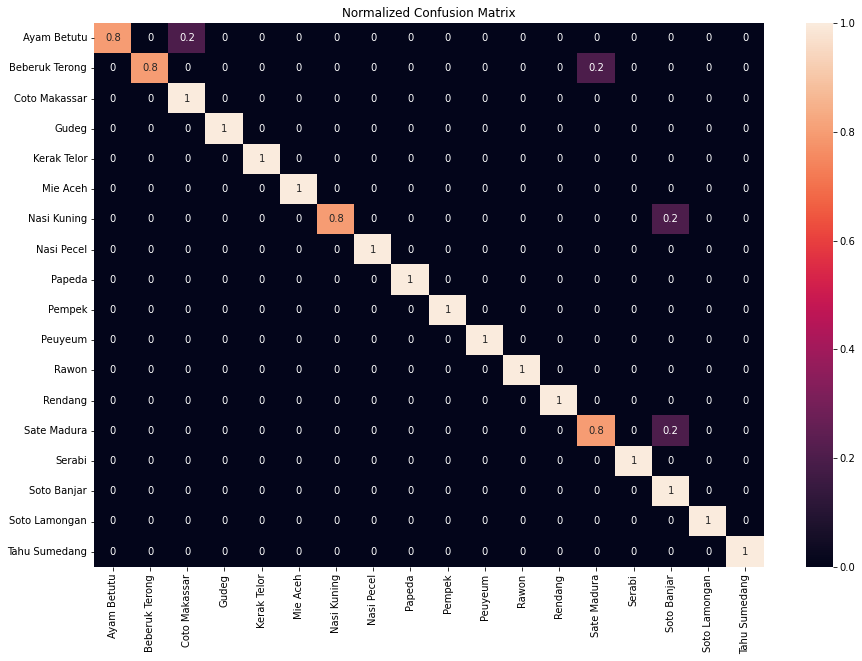

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

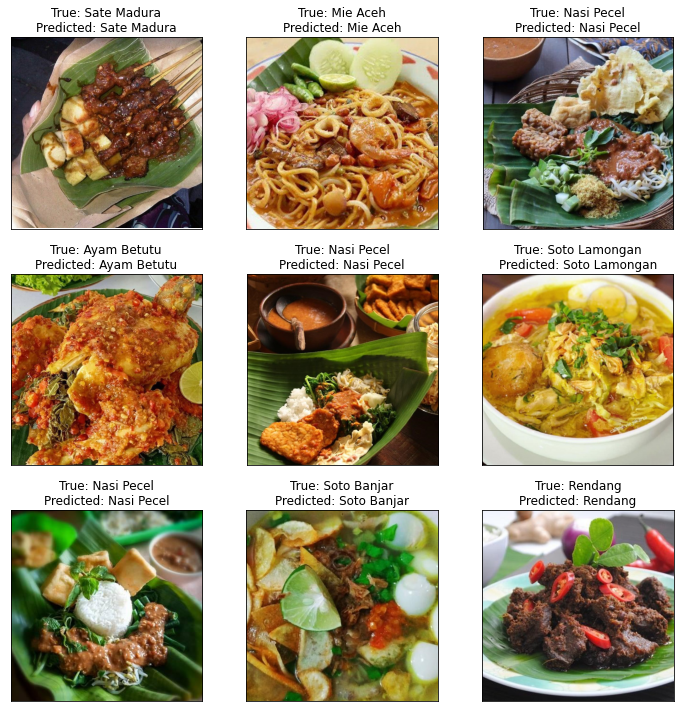

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout() 
plt.show()

In [ ]:
foods_list = ['Ayam Betutu','Beberuk Terong','Coto Makassar','Gudeg','Kerak Telor','Mie Aceh','Nasi Kuning','Nasi Pecel','Papeda','Pempek','Peuyeum','Rawon','Rendang','Sate Madura','Serabi','Soto Banjar','Soto Lamongan','Tahu Sumedang']

In [ ]:
for food in y_test:
    images_list = os.listdir(os.path.join(test_dir, food))
    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/indonesian foods/test/{food}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        prediction = model_best(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = foods_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_motive == food:
            correct_count += 1
    
    print(f'{food} Predictions --> {correct_count}/5 correct')

Sate Madura Predictions --> 3/5 correct
Mie Aceh Predictions --> 5/5 correct
Nasi Pecel Predictions --> 4/5 correct
Ayam Betutu Predictions --> 4/5 correct
Nasi Pecel Predictions --> 4/5 correct
Soto Lamongan Predictions --> 5/5 correct
Nasi Pecel Predictions --> 4/5 correct
Soto Banjar Predictions --> 5/5 correct
Rendang Predictions --> 4/5 correct
Sate Madura Predictions --> 3/5 correct
Tahu Sumedang Predictions --> 4/5 correct
Mie Aceh Predictions --> 5/5 correct
Tahu Sumedang Predictions --> 4/5 correct
Beberuk Terong Predictions --> 3/5 correct
Nasi Pecel Predictions --> 4/5 correct
Pempek Predictions --> 5/5 correct
Mie Aceh Predictions --> 5/5 correct
Peuyeum Predictions --> 5/5 correct
Serabi Predictions --> 5/5 correct
Soto Banjar Predictions --> 5/5 correct
Rawon Predictions --> 3/5 correct
Ayam Betutu Predictions --> 4/5 correct
Pempek Predictions --> 5/5 correct
Tahu Sumedang Predictions --> 4/5 correct
Beberuk Terong Predictions --> 3/5 correct
Soto Lamongan Predictions --

In [ ]:
food = 'Coto Makassar'
food_path = '/content/indonesian foods/test/'+food+'/'+'CotoMakassar'+'-41.jpg'
img = load_img(food_path, target_size=(224, 224))

img_array = img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, 0)

prediction = model_best(img_array)
pred_idx = np.argmax(prediction)
pred_food = foods_list[pred_idx]
pred_confidence = prediction[0][pred_idx] * 100

if pred_food == food and pred_confidence >= 0.70 :
  print(f'Prediction: {pred_food}, Acc: {pred_confidence}')
else:
  print('food is not available')

Prediction: Coto Makassar, Acc: 99.99911499023438


# **5. Save the result**

In [ ]:
model_save_path = "models"
tf.saved_model.save(model_best, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('models/models.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


# **6. Copy the result to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -av '/content/models' '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2'

'/content/models' -> '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models'
'/content/models/variables' -> '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models/variables'
'/content/models/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models/variables/variables.data-00000-of-00001'
'/content/models/variables/variables.index' -> '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models/variables/variables.index'
'/content/models/assets' -> '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models/assets'
'/content/models/saved_model.pb' -> '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models/saved_model.pb'
'/content/models/models.tflite' -> '/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models/models.tflite'


In [ ]:
!cp "/content/bestmodel_18class.hdf5" "/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models"
!cp "/content/history_18.log" "/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models"
!cp "/content/trainedmodel_18class.hdf5" "/content/drive/MyDrive/CAPSTONE/ML/RASA-MobilenetV2/models"